In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline


### Reading and splitting data

In [6]:
data = pd.read_csv("aqarmap_data/cleaned_housing_data.csv")
data.head(3)

,URL,Price,Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate,Neighbourhood
0,https://aqarmap.com.eg/ar/listing/5923848-for-...,7900000,3,3,176,30.015287,30.983945,4,نصف تشطيب,القاهرة الكبرى,كمبوند تراس
1,https://aqarmap.com.eg/ar/listing/6108263-for-...,13000000,4,4,245,30.100866,31.632139,1,سوبر لوكس,القاهرة الكبرى,طريق مدينتي
2,https://aqarmap.com.eg/ar/listing/6418731-for-...,7500000,3,2,180,30.024799,31.516782,1,سوبر لوكس,القاهرة الكبرى,اللوتس الجديدة


now we Create a feature matrix X_train and target vector y_train. target is "price". our features should be all the columns except Neighbourhood and URL.

In [13]:
X_train = data.drop(columns=["Price","URL","Neighbourhood"])
y_train = data["Price"]
X_train.head()

,Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate
0,3,3,176,30.015287,30.983945,4,نصف تشطيب,القاهرة الكبرى
1,4,4,245,30.100866,31.632139,1,سوبر لوكس,القاهرة الكبرى
2,3,2,180,30.024799,31.516782,1,سوبر لوكس,القاهرة الكبرى
3,4,3,230,30.034311,31.461851,1,اكسترا سوبر لوكس,القاهرة الكبرى
4,2,1,116,29.986745,31.319028,1,سوبر لوكس,القاهرة الكبرى


### Building the model

In [21]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:", y_mean.round(2))

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline).round(2))

Mean apt price: 6447173.62
Baseline MAE: 2839399.42


Create a pipeline named model that contains a OneHotEncoder and Linear regression predictor

In [86]:
model = make_pipeline(
    OneHotEncoder( handle_unknown="ignore" ),
    LinearRegression()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('linearregression', LinearRegression())])

In [87]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 1310387.8190976335


### Communicate Results

In [88]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 977
[1014153.52528118  735349.09947372   95783.04016569  448992.72787149
  173383.50426226]


In [89]:

feature_names = model.named_steps["onehotencoder"].get_feature_names_out(X_train.columns)
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 977
['Rooms_1' 'Rooms_2' 'Rooms_3' 'Rooms_4' 'Rooms_5']


In [90]:
feat_imp = pd.Series(coefficients,index=feature_names)
feat_imp.head()

Rooms_1    1.014154e+06
Rooms_2    7.353491e+05
Rooms_3    9.578304e+04
Rooms_4    4.489927e+05
Rooms_5    1.733835e+05
dtype: float64

In [91]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 7649361.65
+ (1014153.53 * Rooms_1)
+ (735349.1 * Rooms_2)
+ (95783.04 * Rooms_3)
+ (448992.73 * Rooms_4)
+ (173383.5 * Rooms_5)
+ (-1190566.71 * Rooms_6)
+ (-1277095.19 * Rooms_7)
+ (-1918968.9 * Baths_1)
+ (-1436627.64 * Baths_2)
+ (-535510.12 * Baths_3)
+ (473074.86 * Baths_4)
+ (233966.91 * Baths_5)
+ (3162394.03 * Baths_6)
+ (21670.86 * Baths_7)
+ (-4801711.77 * Area_5)
+ (-5417093.31 * Area_15)
+ (-1256632.09 * Area_30)
+ (-5724468.52 * Area_32)
+ (-5779988.81 * Area_33)
+ (-5536201.49 * Area_34)
+ (-4815553.11 * Area_35)
+ (-4962849.69 * Area_36)
+ (-4504306.35 * Area_37)
+ (-5304418.33 * Area_38)
+ (-4548305.96 * Area_39)
+ (-4457624.48 * Area_40)
+ (-5069899.01 * Area_41)
+ (-4990530.63 * Area_42)
+ (-4971694.18 * Area_43)
+ (-4756981.73 * Area_44)
+ (-5213205.25 * Area_45)
+ (-4898399.99 * Area_46)
+ (-5837877.82 * Area_47)
+ (-4451218.99 * Area_48)
+ (-4754571.48 * Area_49)
+ (-4760370.85 * Area_50)
+ (-4720645.77 * Area_51)
+ (-4670487.36 * Area_52)
+ (-4215337.58 *

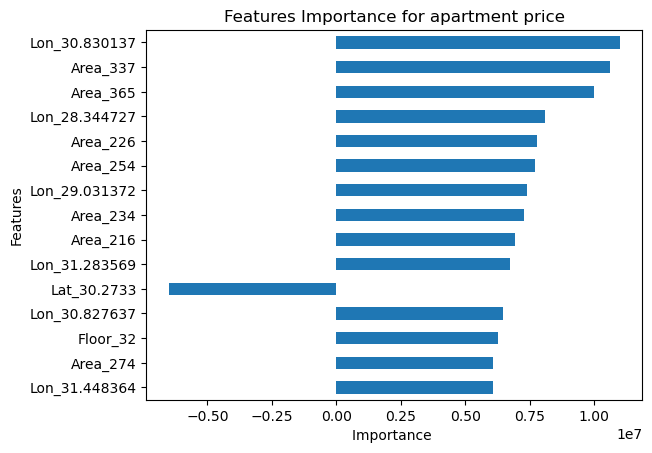

In [92]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance ")
plt.ylabel("Features")
plt.title("Features Importance for apartment price");

In [93]:

def make_prediction(Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate):
    data = {"Rooms":Rooms,
            "Baths" :Baths,
            "Area":Area,
            "Lat":Lat,
            "Lon":Lon,
            "Floor":Floor,
            "Finishing":Finishing,
            "Governate":Governate
           }
    df = pd.DataFrame(data, index=[0])
    print(df)
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"
make_prediction(2,2,120,30.0444,31.2357,3,"لوكس","القاهره الكبري")

   Rooms  Baths  Area      Lat      Lon  Floor Finishing       Governate
0      2      2   120  30.0444  31.2357      3      لوكس  القاهره الكبري


'Predicted apartment price: $4331288.85'

In [96]:
interact(
    make_prediction, 
    # Match the argument name 'Area' from the function
    Area=IntSlider(
        min=int(X_train["Area"].min()), 
        max=int(X_train["Area"].max()), 
        value=int(X_train["Area"].mean()),
    ),
    Lat=FloatSlider(
        min=X_train["Lat"].min(), 
        max=X_train["Lat"].max(), 
        step=0.01, 
        value=X_train["Lat"].mean(),
    ),
    Lon=FloatSlider(
        min=X_train["Lon"].min(), 
        max=X_train["Lon"].max(), 
        step=0.01, 
        value=X_train["Lon"].mean(),
    ),
    # Added missing sliders for Rooms, Baths, Floor, and Finishing
    Rooms=IntSlider(min=1, max=10, step=1, value=3),
    Baths=IntSlider(min=1, max=5, step=1, value=2),
    Floor=IntSlider(min=0, max=20, step=1, value=1),
    Finishing=Dropdown(options=sorted(X_train["Finishing"].unique())),
    # Match 'Governate' with your function argument
    Governate=Dropdown(options=sorted(X_train["Governate"].unique()))
);

interactive(children=(IntSlider(value=3, description='Rooms', max=10, min=1), IntSlider(value=2, description='…